In [1]:
import h5py

# 破解h5

In [2]:
f = h5py.File("/home/nandahgy/yqc_model/1_MODFLOW/1.h5",'r')
list(f.keys())

['Arrays',
 'Drain',
 'Drain Return',
 'ET',
 'ETS',
 'File Type',
 'File Version',
 'General Head',
 'MFH5 Version',
 'MNW2',
 'Multi-Node Well',
 'Recharge',
 'River',
 'SUB',
 'Specified Head',
 'Stream',
 'Stream (SFR2)',
 'UZF',
 'Well']

In [3]:
print(f['Recharge']['07. Property'])
print(f['Recharge']['07. Property'][0][0][:])
print(f['Recharge']['07. Property'][0][93561][:])

<HDF5 dataset "07. Property": shape (1, 93562, 3), type "<f8">
[0. 0. 0.]
[0. 0. 0.]


In [4]:
NROW = 287
NCOL = 326
# for i in range(93562):
#   if f['Recharge']['07. Property'][0][i][0] != 0:
#     print(i//NCOL)

In [5]:
import numpy as np

In [6]:
NROW = 287
NCOL = 326
nums = [0]*93562

nums = list(f['Arrays']['ibound1'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound1 = np.array(tmp)



nums = list(f['Arrays']['ibound2'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound2 = np.array(tmp)


nums = list(f['Arrays']['ibound3'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound3 = np.array(tmp)

In [7]:
nums = list(f['Arrays']['top1'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
top1 = np.array(tmp)

In [8]:
# nums = list(f['Arrays']['bot1'])
# tmp = []
# for i in range(NROW):
#   tmp.append(nums[i*NCOL:(1+i)*NCOL])
# bot1 = np.array(tmp)

# nums = list(f['Arrays']['bot2'])
# tmp = []
# for i in range(NROW):
#   tmp.append(nums[i*NCOL:(1+i)*NCOL])
# bot2 = np.array(tmp)

# nums = list(f['Arrays']['bot3'])
# tmp = []
# for i in range(NROW):
#   tmp.append(nums[i*NCOL:(1+i)*NCOL])
# bot3 = np.array(tmp)

In [9]:
# bot3[100,100]

In [10]:
nums1 = list(f['Arrays']['StartHead1'])
tmp = []
for i in range(NROW):
  tmp.append(nums1[i*NCOL:(1+i)*NCOL])
StartHead1 = np.array(tmp) 

nums = list(f['Arrays']['StartHead2'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
StartHead2 = np.array(tmp) 

nums = list(f['Arrays']['StartHead3'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
  # print(nums[i*NCOL:(1+i)*NCOL])
StartHead3 = np.array(tmp) 

# 基于mf6的溶质运移模型(再试一遍)

https://zhuanlan.zhihu.com/p/532012679

In [11]:
# Filename
sim_ws = 'simulation2'
sim_name = 'model'          # 模拟总名称
gwfname = "gwf_" + sim_name # 渗流模型名称
gwtname = "gwt_" + sim_name # 溶质运移模型名称

In [12]:
# Units
length_units = "meters"   # 长度单位
time_units = "days"       # 时间单位

## 离散层数

In [13]:
# Discretization
import numpy as np
nper = 1                  # 稳定流，周期数为 1
nlay = 3                  # 层数
nrow = 287                 # 行数
ncol = 326                 # 列数
delr = 10.0               # 单位行长
delc = 10.0               # 单位列长
# delz = 10.0               # 单位层高
Lx = delr * nrow
Ly = delc * ncol
top = 3.0                 # 顶部高程
botm = [-3.0,-17.0,-32.0]
# botm = [-delz * k for k in range(1, nlay + 1)]     # 底部高程（多层，为列表）
idomain = np.ones((nlay, nrow, ncol), dtype = int) # 参与模拟的区域，1 为参与
idomain[0,:,:] = ibound1
idomain[1,:,:] = ibound2
idomain[2,:,:] = ibound3

In [14]:
botm

[-3.0, -17.0, -32.0]

In [15]:
# 设置溶质运移模型专门参数:
# GWT
porosity = 0.2
al = 50.0                    # 纵向弥散系数
trpt = 0.3; ath1 = al * trpt # 横向弥散系数
trpv = 0.3; atv = al * trpv  # 垂直弥散系数

# 设置渗流模型专门参数:

# GWF
icelltype = 0
k11 = 0.5
k33 = k11

In [16]:
# 时间离散化参数:
# Temporal discretization
perlen = 100.0
nstp = 10
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult),)
print(tdis_ds)

# 求解器参数：
# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

[(100.0, 10, 1.0)]


In [17]:
# 初始条件: # Initial conditions
# Starting concentrations 初始浓度
sconc = 0.0
# Starting Heads 初始水头
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0,:,:] = StartHead1
strt[1,:,:] = StartHead2
strt[2,:,:] = StartHead3

print(StartHead1[100,100])
print(StartHead2[100,100])
print(StartHead3[100,100])

3.0
-3.0
-17.0


## 井

In [18]:
# 边界条件: # Boundary conditions
# wel_spd 井
qwell = 0
cwell = 1000.0
wel_loc = (2, 100, 100)
#               (k, i, j),  flow,  conc
wel_spd = {0: [[wel_loc, qwell, cwell]]}


In [40]:
# chd_spd 指定水头
chd_spd = []
cnt = 0
for k in np.arange(nlay): # 东西两侧分别指定
    # for i in np.arange(nrow):
    #     #               (l, r, c),          head, conc
    #     chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
    #     chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 100.0])

    for j in np.arange(ncol): # 南北两侧分别指定
        for i in np.arange(nrow):
            #         (l, r, c),    head, conc
            if idomain[k][i][j] == 1:
              chd_spd.append([(k, i, j), strt[k, i, j], 100.0])
              cnt += 1
              break
        for i in np.arange(nrow-1,-1,-1):
            #         (l, r, c),    head, conc
            if idomain[k][i][j] == 1:
              chd_spd.append([(k, i, j), strt[k, i, j], 100.0])
              cnt += 1
              break
print(chd_spd[1000:1010])
chd_spd = {0: chd_spd}
cnt

[[(1, 6, 200), -3.0, 100.0], [(1, 221, 200), -3.0, 100.0], [(1, 6, 201), -3.0, 100.0], [(1, 219, 201), -3.0, 100.0], [(1, 6, 202), -3.0, 100.0], [(1, 217, 202), -3.0, 100.0], [(1, 6, 203), -3.0, 100.0], [(1, 215, 203), -3.0, 100.0], [(1, 6, 204), -3.0, 100.0], [(1, 212, 204), -3.0, 100.0]]


1866

In [20]:
# chd_spd 指定水头
# chd_spd = []
# for k in np.arange(nlay): # 东西两侧分别指定
#     for i in np.arange(nrow):
#         #               (l, r, c),          head, conc
#         chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
#         chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
# chd_spd = {0: chd_spd}

# print(chd_spd)

## 建模并计算

In [21]:
import flopy
def build_model():
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6'
    )

    # 时间离散化
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units
    )

    # GWF
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    # 渗流模型求解参数
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwfname),
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # 离散化
    dis6 = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwfname),
    )

    # 含水层特性
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=0.5,
        k22=1.0,
        k33=3.0,
        save_specific_discharge=True,
        filename="{}.npf".format(gwfname),
    )
    

    # 初始水头
    flopy.mf6.ModflowGwfic(
        gwf, strt=strt, filename="{}.ic".format(gwfname)
    )

    # 指定水头边界
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chd_spd),
        stress_period_data=chd_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename="{}.chd".format(gwfname),
    )

    # 井边界
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename="{}.wel".format(gwfname),
    )

    # 补给recharge
    flopy.mf6.ModflowGwfrcha(
        gwf,
        recharge=0.0001,
        filename="{}.rch".format(gwfname),
    )

    # 蒸发
    flopy.mf6.ModflowGwfevta(
        gwf,
        surface=2.0,
        rate=0.000103,
        depth=5.0,
        filename="{}.evt".format(gwfname),
    )

    # 输出控制
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord="{}.hds".format(gwfname),
        budget_filerecord="{}.bud".format(gwfname),
        headprintrecord=[
            ("COLUMNS", 100, "WIDTH", 150, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # GWT
    gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwtname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwtname),
    )

    # 溶质运移模型求解参数
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwtname),
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # 离散化
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwtname),
    )

    # 初始浓度
    flopy.mf6.ModflowGwtic(
        gwt, strt=sconc, filename="{}.ic".format(gwtname)
    )

    # 对流
    flopy.mf6.ModflowGwtadv(
        gwt, scheme="UPSTREAM", filename="{}.adv".format(gwtname)
    )

    # 弥散
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al,
        ath1=ath1,
        atv=atv,
        filename="{}.dsp".format(gwtname),
    )

    # 化学反应 (等同于 MT3DMS 的 reaction)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename="{}.mst".format(gwtname),
    )

    # 源汇项
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
        gwt, sources=sourcerecarray, filename="{}.ssm".format(gwtname)
    )

    # 输出控制
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord="{}.cbc".format(gwtname),
        concentration_filerecord="{}.ucn".format(gwtname),
        concentrationprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
    )

    # GWF 和 GWT 之间的交换
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename="{}.gwfgwt".format(sim_name),
    )
    return sim, gwf, gwt, dis6

sim, gwf, gwt, dis6 = build_model()
sim.write_simulation(silent = True)

success, buff = sim.run_simulation(silent = True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

## 查看结果

In [22]:
# 运行完毕后，分别读取水头和浓度结果（我们使用 get_alldata 读取了全部时刻的结果）:

head = gwf.oc.output.head().get_alldata()
concentration = gwt.oc.output.concentration().get_alldata()

# 我们可以查看结果的维度:

print(head.shape)
print(concentration.shape)

# 10: 时间 - nstp 值。
# (8, 15, 21): 网格空间

(10, 3, 287, 326)
(10, 3, 287, 326)


In [23]:
# print(head[9,2])
print(concentration[9,1])

[[1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 ...
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]]


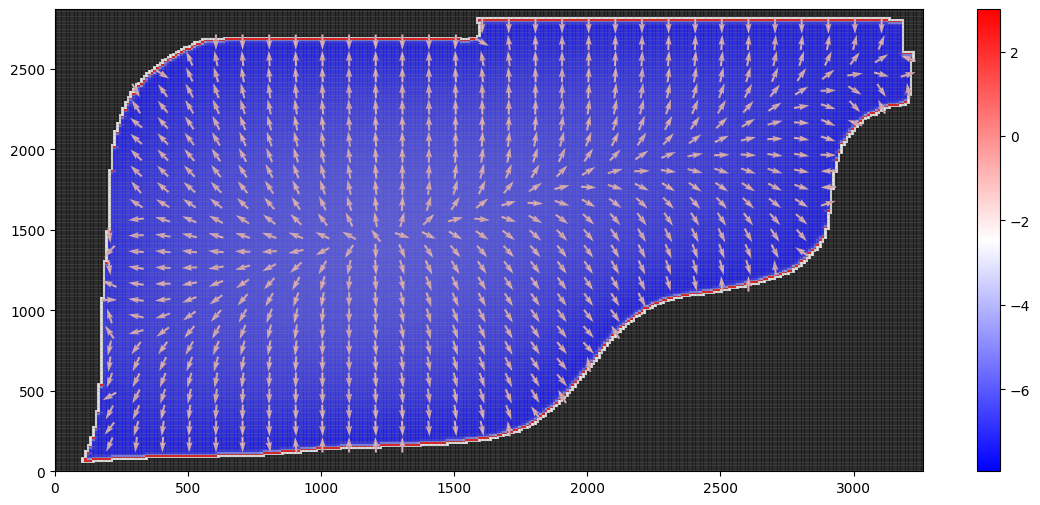

In [43]:
import matplotlib.pyplot as plt
def plot_results(model, result):
    fig = plt.figure(figsize = (14, 6))
    ax = fig.add_subplot(1, 1, 1)
    pmv = flopy.plot.PlotMapView(model = model, ax = ax, layer = 0)
    pmv.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
    
    # 网格填充颜色
    plot_array = pmv.plot_array(head[9,0], masked_values = [1e30], cmap = 'bwr')
    plt.colorbar(plot_array)
    
    # 绘制等值线
    plot_contour_array = pmv.contour_array(result, masked_values = [1e30], cmap = "brg", linestyles="--")
    plt.clabel(plot_contour_array, fmt = r'%.2f') # 绘制等值线上文本标注
    # plt.colorbar(plot_contour_array)              # 等值线图例
    
    pmv.plot_bc(package = gwf.get_package("WEL-1"), color = 'green')
    pmv.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')
    
    # 绘制水流的方向 (粉红色箭头)
    spdis = gwf.oc.output.budget().get_data(text = 'DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    pmv.plot_vector(qx, qy, normalize = True, istep = 10, jstep = 10, color = "pink")
    
plot_results(model = gwf, result = concentration[9,0])

# MODPATH7 Model

In [25]:
# Define names for the MODPATH 7 simulations
mp_namea = sim_name + "a_mp"
mp_nameb = sim_name + "b_mp"

In [26]:
# create particles
# particle group 1
# plocs = []
# pids = []
# for idx in range(nrow):
#     plocs.append((0, idx, 2))
#     pids.append(idx)
# part0 = flopy.modpath.ParticleData(
#     plocs, drape=0, structured=True, particleids=pids
# )
# locs = [(0, 0, 0), (1, 0, 0), (2, 0, 0)]

In [27]:
pcoord = np.array(
    [
        [0.000, 0.125, 0.500],
        [0.000, 0.375, 0.500],
        [0.000, 0.625, 0.500],
        [0.000, 0.875, 0.500],
        [1.000, 0.125, 0.500],
        [1.000, 0.375, 0.500],
        [1.000, 0.625, 0.500],
        [1.000, 0.875, 0.500],
        [0.125, 0.000, 0.500],
        [0.375, 0.000, 0.500],
        [0.625, 0.000, 0.500],
        [0.875, 0.000, 0.500],
        [0.125, 1.000, 0.500],
        [0.375, 1.000, 0.500],
        [0.625, 1.000, 0.500],
        [0.875, 1.000, 0.500],
    ]
)

# pcoord.shape[0]

nodew = (2, 100, 100)
plocs = [nodew for i in range(pcoord.shape[0])]
# create particle data
pa = flopy.modpath.ParticleData(
    plocs,
    structured=True,
    localx=pcoord[:, 0],
    localy=pcoord[:, 1],
    localz=pcoord[:, 2],
    drape=0,
)

# create backward particle group
fpth = mp_namea + ".sloc"
pga = flopy.modpath.ParticleGroup(
    particlegroupname="BACKWARD1", particledata=pa, filename=fpth
)

In [28]:
model_ws="/home/nandahgy/simulation"
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_namea, flowmodel=gwf, exe_name="/usr/local/lib/modflow/mp7", model_ws=model_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=porosity)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=pga,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mp7

MODPATH Version 7.2.001   
Program compiled Mar 08 2022 20:16:00 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        16 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

加载pathline和timeseries数据

In [29]:
import os

In [30]:
import pandas

In [31]:
fpth = os.path.join(model_ws, mp_namea + ".mppth")
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()
fpth = os.path.join(model_ws, mp_namea + ".timeseries")
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

In [32]:
# 画出endpoint
fpth = os.path.join(model_ws, mp_namea + ".mpend")
e = flopy.utils.EndpointFile(fpth)
e0 = e.get_alldata()

## 画出endpoint

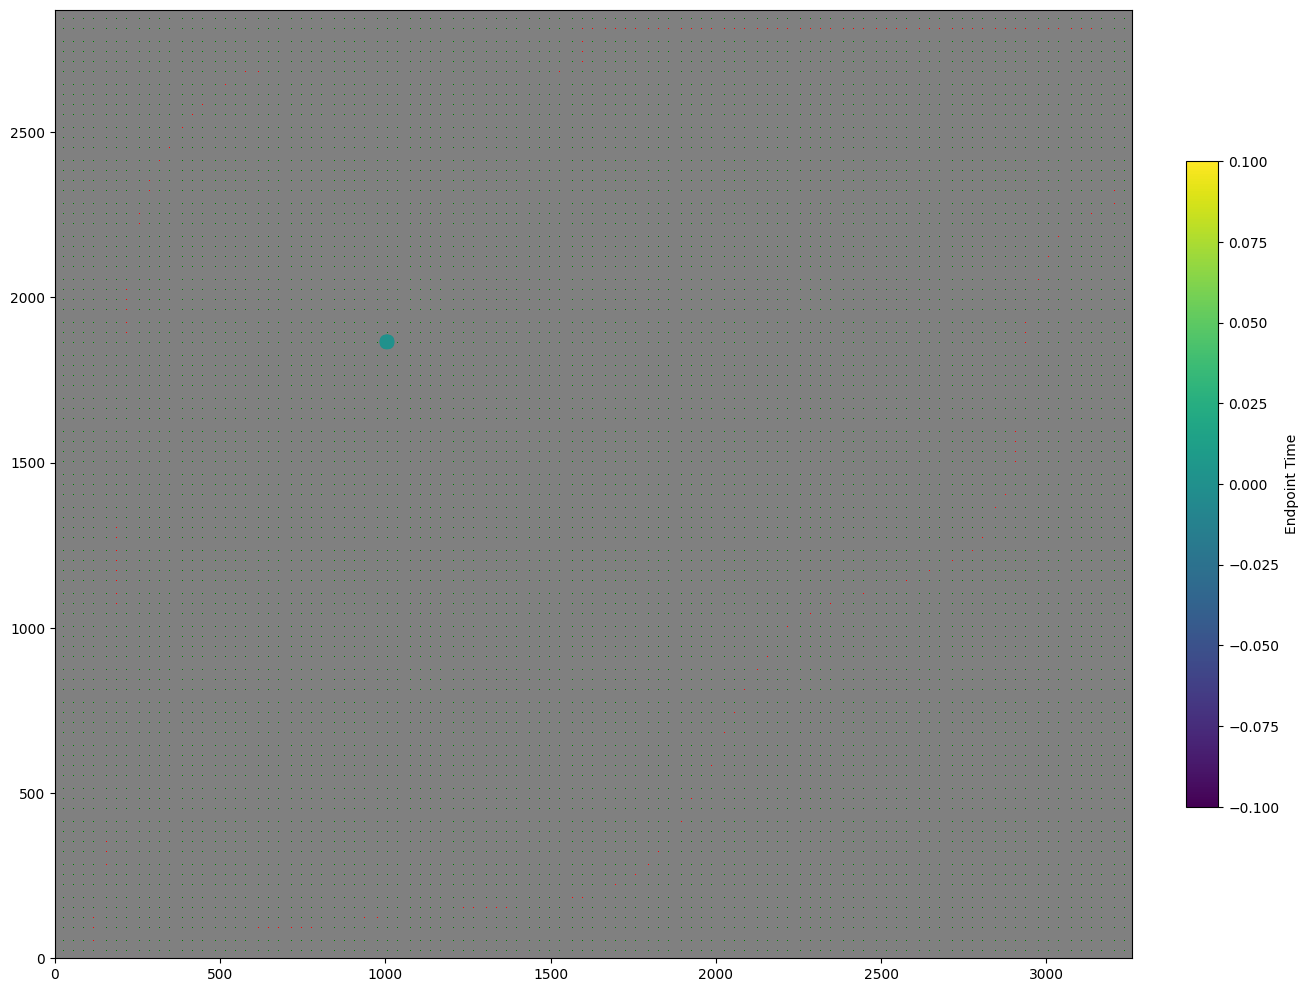

In [33]:
import matplotlib as mpl
fig = plt.figure(figsize=(13, 13), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
pmv = flopy.plot.PlotMapView(model = gwf, ax = ax, layer = 0)
plot_array = pmv.plot_array(head[9,0], masked_values = [1e30], cmap = 'bwr')
# plt.colorbar(plot_array)
v = mm.plot_array(ibound1, cmap=cmap, edgecolor="gray")
mm.plot_endpoint(e0, direction="ending", colorbar=True, shrink=0.5);

## 画出pathline和timeseries数据

/usr/local/lib/python3.9/dist-packages/flopy/plot/map.py:243: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


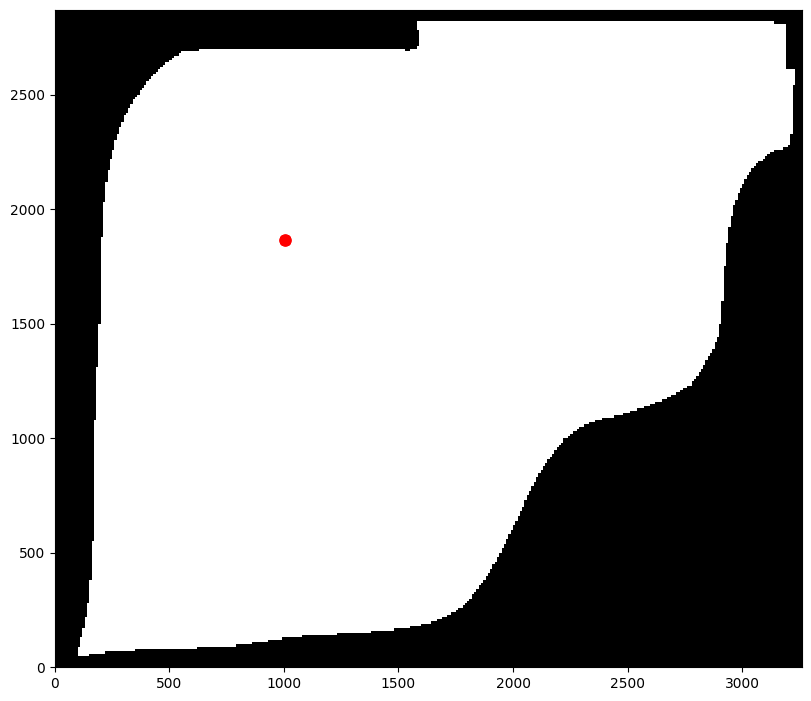

In [34]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)
# pmv = flopy.plot.PlotMapView(model = gwf, ax = ax, layer = 0)
# mm.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(gwf.modelgrid.idomain, cmap=cmap, edgecolor="white")
mm.plot_pathline(p0, layer="all", color="blue", lw=0.75)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k]);

# 绘制等值线
plot_contour_array = mm.contour_array(concentration[9,0], masked_values = [1e30], cmap = "brg", linestyles="--")
plt.clabel(plot_contour_array, fmt = r'%.2f') # 绘制等值线上文本标注
# plt.colorbar(plot_contour_array)              # 等值线图例

mm.plot_bc(package = gwf.get_package("WEL-1"), color = 'green')
mm.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')

